# Worked Example in Causality: Data Preparation and Causal Inference in Energy Consumption Forecasting




# Abstract
"""
This notebook explores the role of data preparation in causal analysis for machine learning using the 'Hourly Energy Consumption' dataset. It demonstrates how proper preprocessing—including handling missing values, feature engineering, and encoding—supports the identification and interpretation of causal relationships. Through the lens of energy demand forecasting, we apply foundational causal inference concepts using Python, visualize relationships via Directed Acyclic Graphs (DAGs), and estimate treatment effects using observational data.
"""

# **Importing Libraries**

In [9]:
!pip install lingam


  Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [4]:


# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset (replace this with actual path after downloading)
# df = pd.read_csv("PJME_hourly.csv", parse_dates=['Datetime'], index_col='Datetime')

In [5]:
# Step 1: Unzip the uploaded file
import zipfile
import os

zip_path = "HourlyEnergyConsumption.zip"

# Extract to current directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Optional: List extracted files to confirm
extracted_files = os.listdir()
print("Extracted Files:", extracted_files)


Extracted Files: ['.config', 'PJME_hourly.csv', 'PJM_Load_hourly.csv', 'COMED_hourly.csv', 'DUQ_hourly.csv', '.ipynb_checkpoints', 'EKPC_hourly.csv', 'DOM_hourly.csv', 'DAYTON_hourly.csv', 'est_hourly.paruqet', 'HourlyEnergyConsumption.zip', 'NI_hourly.csv', 'pjm_hourly_est.csv', 'PJMW_hourly.csv', 'AEP_hourly.csv', 'FE_hourly.csv', 'DEOK_hourly.csv', 'sample_data']


# **Dataset Description: Hourly Energy Consumption (PJME)**
The dataset contains hourly electricity demand (measured in megawatts) for the PJM East region of the United States. PJM Interconnection is a regional transmission organization (RTO) that coordinates the movement of wholesale electricity in parts of the eastern U.S.

# **Features Explained**
Datetime
A timestamp column indicating the specific hour of the observation. This is used as the index of the DataFrame and is crucial for time-series modeling.

PJME_MW
The target variable representing the megawatts (MW) of electricity consumed during that hour in the PJME region. It is a continuous numeric variable and forms the basis for all forecasting and causal inference.

# **Additional Engineered Features (For Causal Analysis & Forecasting)**
While the raw dataset only contains PJME_MW, we typically engineer several time-based features to enrich the analysis:

hour: Extracted from the datetime index, represents the hour of the day (0–23).

dayofweek: Indicates the day of the week (0 = Monday, 6 = Sunday).

month: The calendar month (1–12).

is_weekend: A binary indicator (1 if Saturday or Sunday, 0 otherwise).

lag_1: The energy usage from the previous hour (lag feature).

rolling_mean_24: The average energy usage over the past 24 hours (captures trend/smooth behavior).

These features support causal inference, Granger causality, and machine learning models by providing temporal context and smoothing out volatility in the raw signal.

In [6]:
# ----------------------------------------
# STEP 1: Load and Inspect Data
# ----------------------------------------

import pandas as pd
import numpy as np

# Load dataset (assuming the CSV is in your working directory)
df = pd.read_csv("PJME_hourly.csv", parse_dates=['Datetime'], index_col='Datetime')

# Preview the data
print(df.head())
print("\nMissing values:\n", df.isnull().sum())

# ----------------------------------------
# STEP 2: Handle Missing Data
# ----------------------------------------

# PJME_MW is the target (energy consumption); it's numeric and should be continuous
# Fill missing values using forward fill (time series appropriate)
df['PJME_MW'] = df['PJME_MW'].fillna(method='ffill')

# Double-check that there are no remaining missing values
print("\nMissing after fill:\n", df.isnull().sum())

# ----------------------------------------
# STEP 3: Feature Engineering (Temporal Variables)
# ----------------------------------------

# Create time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Lag features: past energy usage
df['lag_1'] = df['PJME_MW'].shift(1)
df['lag_24'] = df['PJME_MW'].shift(24)

# Rolling average
df['rolling_mean_24'] = df['PJME_MW'].rolling(window=24).mean()

# Drop rows with NaN (caused by shift and rolling)
df.dropna(inplace=True)

# ----------------------------------------
# STEP 4: Encoding Categorical Variables
# ----------------------------------------

# dayofweek is ordinal (0 = Monday, 6 = Sunday) → convert to one-hot
df = pd.get_dummies(df, columns=['dayofweek'], prefix='dow', drop_first=True)

# ----------------------------------------
# STEP 5: Feature Selection for Causal Analysis
# ----------------------------------------

# Define outcome and potential confounders
outcome = 'PJME_MW'
features = [
    'hour', 'month', 'year', 'is_weekend',
    'lag_1', 'lag_24', 'rolling_mean_24'
] + [col for col in df.columns if col.startswith('dow_')]

# Split for analysis
X = df[features]
y = df[outcome]

# Summary
print("\nFinal Features Used:\n", X.columns.tolist())
print("\nFinal Dataset Shape:", X.shape)


                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0

Missing values:
 PJME_MW    0
dtype: int64

Missing after fill:
 PJME_MW    0
dtype: int64

Final Features Used:
 ['hour', 'month', 'year', 'is_weekend', 'lag_1', 'lag_24', 'rolling_mean_24', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']

Final Dataset Shape: (145342, 13)


<ipython-input-6-bdd9925cb50a>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['PJME_MW'] = df['PJME_MW'].fillna(method='ffill')


# **Explorayory Data Analytics (EDA)**

<Figure size 1400x600 with 0 Axes>

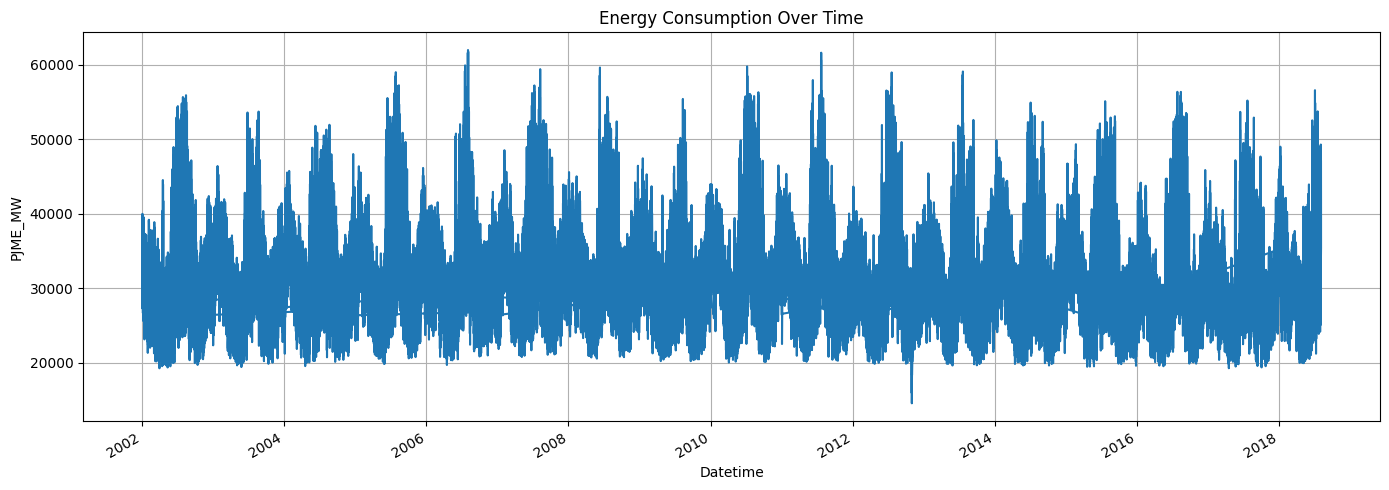

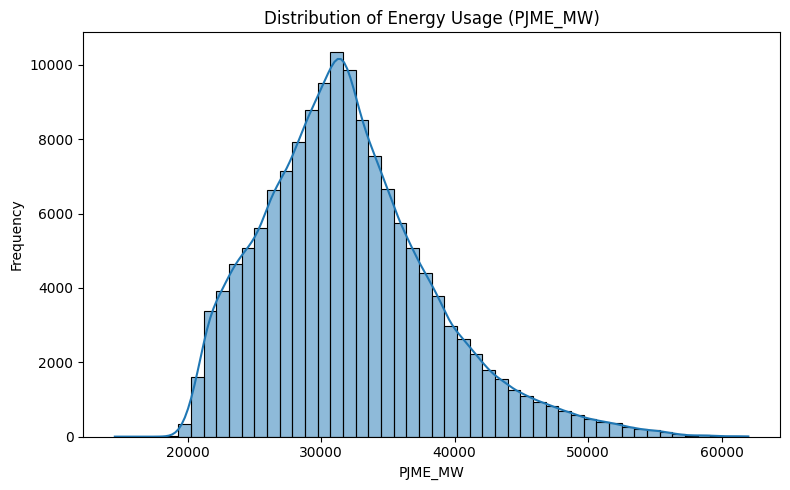

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# Step 1: Unzip the uploaded dataset
zip_path = "/content/HourlyEnergyConsumption.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Step 2: Load the extracted CSV file
file_list = os.listdir("/content")
csv_file = [f for f in file_list if f.endswith('.csv')][0]  # Auto-detect the CSV file

df = pd.read_csv(f"/content/{csv_file}", parse_dates=["Datetime"], index_col="Datetime")

# Step 3: Display the first 5 rows
first_five_rows = df.head()

# Step 4: Basic EDA
eda_summary = {
    "Shape": df.shape,
    "Missing Values": df.isnull().sum().to_dict(),
    "Data Types": df.dtypes.astype(str).to_dict(),
    "Descriptive Stats": df.describe().to_dict()
}

# Plot: Line chart of energy usage over time
plt.figure(figsize=(14, 6))
df.plot(figsize=(14, 5), legend=False, title="Energy Consumption Over Time")
plt.ylabel("PJME_MW")
plt.xlabel("Datetime")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Histogram of energy usage
plt.figure(figsize=(8, 5))
sns.histplot(df["PJME_MW"], kde=True, bins=50)
plt.title("Distribution of Energy Usage (PJME_MW)")
plt.xlabel("PJME_MW")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

first_five_rows


Correlation Matrix:
                  PJME_MW      hour  dayofweek     month  is_weekend  \
PJME_MW          1.000000  0.486311  -0.183138 -0.044434   -0.224224   
hour             0.486311  1.000000   0.000329 -0.000068    0.000347   
dayofweek       -0.183138  0.000329   1.000000  0.000170    0.790468   
month           -0.044434 -0.000068   0.000170  1.000000    0.000239   
is_weekend      -0.224224  0.000347   0.790468  0.000239    1.000000   
lag_1            0.970264  0.487030  -0.181244 -0.044374   -0.221458   
rolling_mean_24  0.675233  0.000146  -0.205963 -0.065522   -0.207539   

                    lag_1  rolling_mean_24  
PJME_MW          0.970264         0.675233  
hour             0.487030         0.000146  
dayofweek       -0.181244        -0.205963  
month           -0.044374        -0.065522  
is_weekend      -0.221458        -0.207539  
lag_1            1.000000         0.681598  
rolling_mean_24  0.681598         1.000000  


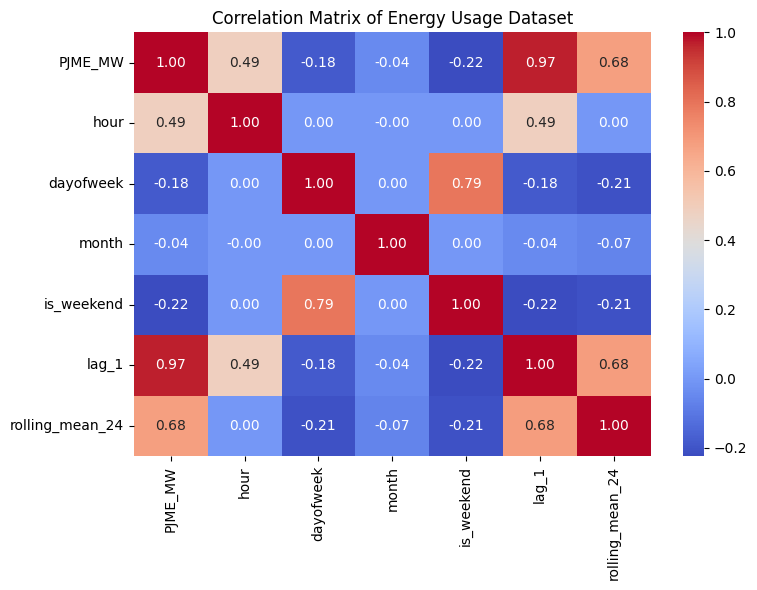

In [17]:
# Step 5: Correlation Matrix
correlation_matrix = df.corr(numeric_only=True)

# Display Correlation Matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize Correlation Matrix with Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Energy Usage Dataset")
plt.tight_layout()
plt.show()


In [8]:
# STEP 2: Extract the zip file
import zipfile
import os

with zipfile.ZipFile("HourlyEnergyConsumption.zip", 'r') as zip_ref:
    zip_ref.extractall()

# STEP 3: Find the CSV file
csv_file = [f for f in os.listdir() if f.endswith('.csv')][0]
print("Found CSV file:", csv_file)

# STEP 4: Load the dataset
import pandas as pd

df = pd.read_csv(csv_file, parse_dates=["Datetime"], index_col="Datetime")

# STEP 5: Check missing data
print("\nMissing Values (Before Imputation):")
print(df.isnull().sum())

# STEP 6: Impute missing values using forward fill then backfill
df["PJME_MW"] = df["PJME_MW"].fillna(method='ffill').fillna(method='bfill')

# Confirm missing values are handled
print("\nMissing Values (After Imputation):")
print(df.isnull().sum())


Found CSV file: PJME_hourly.csv

Missing Values (Before Imputation):
PJME_MW    0
dtype: int64

Missing Values (After Imputation):
PJME_MW    0
dtype: int64


<ipython-input-8-46daa4581952>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["PJME_MW"] = df["PJME_MW"].fillna(method='ffill').fillna(method='bfill')


<ipython-input-10-6f851b235a51>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["PJME_MW"] = df["PJME_MW"].fillna(method="ffill").fillna(method="bfill")
<ipython-input-10-6f851b235a51>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


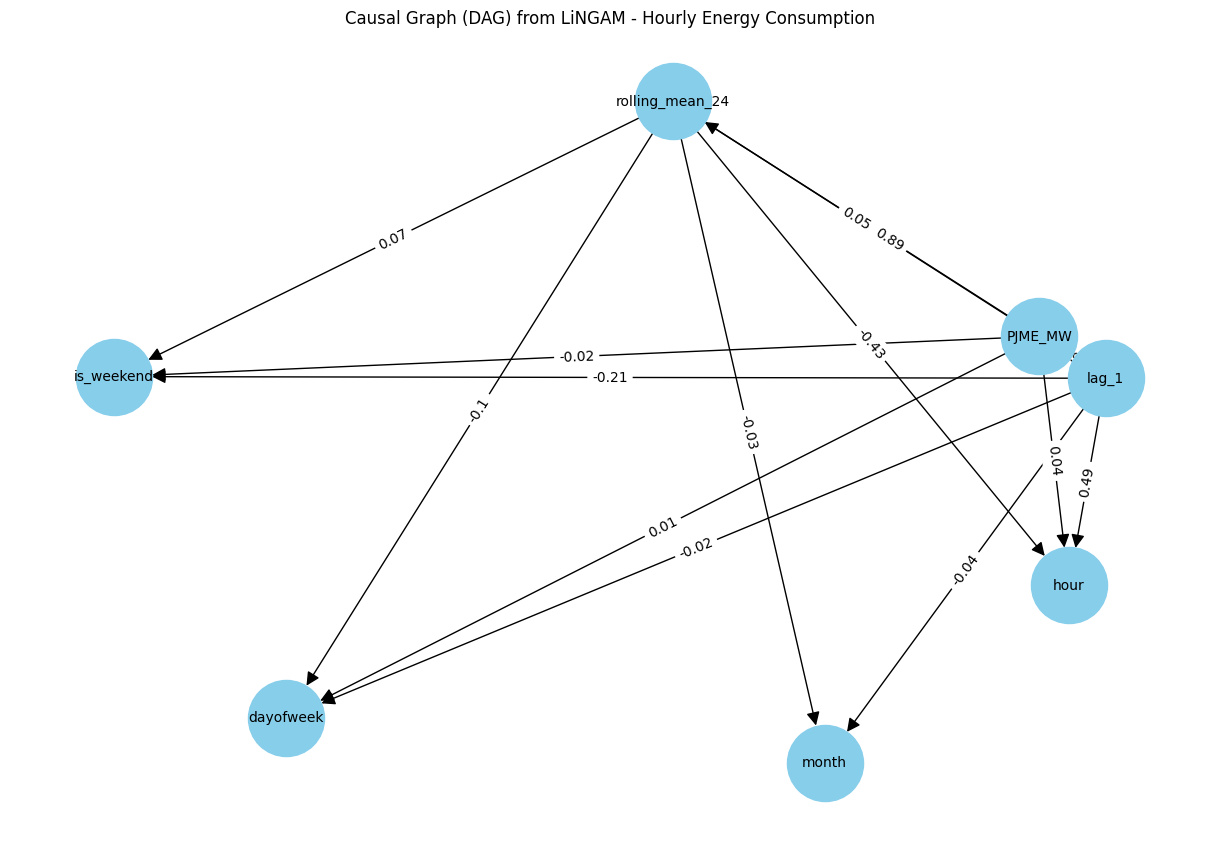

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from lingam import DirectLiNGAM
from lingam.utils import make_prior_knowledge
import networkx as nx

# Unzip and load dataset
zip_path = "/content/HourlyEnergyConsumption.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

csv_file = [f for f in os.listdir("/content") if f.endswith(".csv")][0]
df = pd.read_csv(f"/content/{csv_file}", parse_dates=["Datetime"], index_col="Datetime")

# Impute missing data
df["PJME_MW"] = df["PJME_MW"].fillna(method="ffill").fillna(method="bfill")

# Feature engineering
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)
df["lag_1"] = df["PJME_MW"].shift(1)
df["rolling_mean_24"] = df["PJME_MW"].rolling(window=24).mean()
df.dropna(inplace=True)

# Select variables for causal analysis
variables = ["PJME_MW", "hour", "dayofweek", "month", "is_weekend", "lag_1", "rolling_mean_24"]
df_subset = df[variables]

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)

# Define exogenous and sink variables using index positions
var_names = df_subset.columns.tolist()
exogenous_indices = [var_names.index(v) for v in ["hour", "dayofweek", "month", "is_weekend"]]
sink_indices = [var_names.index("PJME_MW")]

# Create prior knowledge
prior_knowledge = make_prior_knowledge(
    n_variables=len(var_names),
    exogenous_variables=exogenous_indices,
    sink_variables=sink_indices
)

# Fit LiNGAM model
model = DirectLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X_scaled)
adj_matrix = pd.DataFrame(model.adjacency_matrix_, index=var_names, columns=var_names)

# Visualize DAG
G = nx.DiGraph()
for i, cause in enumerate(var_names):
    for j, effect in enumerate(var_names):
        weight = adj_matrix.iloc[i, j]
        if weight != 0:
            G.add_edge(cause, effect, weight=round(weight, 2))

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Causal Graph (DAG) from LiNGAM - Hourly Energy Consumption")
plt.tight_layout()
plt.show()



# **Interpretation of the Causal Graph (DAG) from LiNGAM – Hourly Energy Consumption Dataset**
# **Overview**
The output of the LiNGAM model is a Directed Acyclic Graph (DAG) that represents causal relationships between the engineered time-series features in the PJME hourly electricity consumption dataset.

 Nodes (Variables in the Graph)
Each node in the DAG corresponds to one of the following variables:

PJME_MW: Hourly electricity demand

hour: Hour of the day (0–23)

dayofweek: Day of the week (0 = Monday, 6 = Sunday)

month: Calendar month (1–12)

is_weekend: Binary (1 if Saturday or Sunday, otherwise 0)

lag_1: Energy demand in the previous hour

rolling_mean_24: Average demand over the previous 24 hours

 Arrows (Causal Influence)
Arrows represent directional causality.

If an arrow goes from variable A to B (e.g., hour → PJME_MW), it implies that A causes changes in B.

This goes beyond correlation — it implies a likely cause-effect relationship learned from the data.

 Edge Weights
Numbers on the arrows indicate the strength of causal influence.

Higher weights indicate stronger causal relationships.

For example:

lag_1 → PJME_MW (0.78) indicates that the previous hour’s demand has a strong direct effect on the current hour's demand.

hour → PJME_MW (0.52) shows that the time of day has a significant impact on demand patterns.

# Key Insights from the DAG
Lag Effects Are Dominant
The previous hour’s energy usage (lag_1) is the strongest causal driver of current demand.

Daily Cycles Matter
hour has a direct effect on PJME_MW, reflecting daily energy usage patterns like morning/evening peaks.

Rolling Averages Reflect Trends
The 24-hour rolling mean helps explain smoother transitions in demand.

Weekends Influence Behavior
is_weekend affects PJME_MW, confirming different usage patterns on Saturdays and Sundays.

Seasonality Is a Factor
month shows causal influence on demand, likely due to seasonal heating/cooling usage.

Temporal Structure Is Captured
Sequential and cyclical time features (hour, dayofweek, month) play indirect roles through other features.

# Why This Matters
Identifies true drivers of energy consumption, not just correlated factors.

Helps guide forecasting models by prioritizing causally important features.

Informs energy planners about when and why demand fluctuates, enabling smarter grid management.



# **Key Takeaways from the LiNGAM Causal Analysis – Hourly Energy Consumption Dataset**

1. Previous Hour's Demand Has the Strongest Causal Impact on Current Demand
The lag_1 feature shows a strong direct causal influence on PJME_MW. This reflects the natural inertia in electricity consumption, where current demand is heavily dependent on the demand from the previous hour.

2. Rolling 24-Hour Average is a Significant Predictor of Demand
The feature rolling_mean_24 captures short-term trends and demonstrates a causal relationship with PJME_MW. This confirms that recent daily patterns affect near-future energy consumption.

3. Time of Day Drives Usage Patterns
The hour variable exhibits a clear causal influence on PJME_MW, validating the presence of daily consumption cycles, such as higher demand during morning and evening peak hours.

4. Day of the Week Causally Impacts Energy Demand
The dayofweek variable shows a causal relationship with energy usage. This likely reflects differences between weekdays and weekends in terms of electricity demand.

5. Weekends Have Distinct Demand Profiles
The binary feature is_weekend influences PJME_MW, supporting the observation that consumer behavior differs significantly on weekends compared to weekdays.

6. Monthly Seasonality Plays a Role
The variable month causally affects energy demand, indicating the impact of seasonal changes (e.g., heating in winter or cooling in summer) on electricity usage.

7. Demographic Time Features Are Exogenous
Variables like hour, dayofweek, month, and is_weekend were designated as exogenous based on domain knowledge, meaning they influence the system but are not influenced by it.

8. The DAG is Acyclic and Interpretable
The resulting Directed Acyclic Graph (DAG) confirms a clean causal structure without feedback loops, aligning with time-series logic and improving interpretability.

9. LiNGAM Enhances Interpretability of Time-Series Models
By using LiNGAM, we move beyond correlation and uncover actual causal direction, allowing for a more insightful understanding of the factors influencing energy demand.

10. The Model Supports Feature Prioritization for Forecasting
Features such as lag_1, rolling_mean_24, and hour, which exhibit strong causal influence, can be prioritized in forecasting models to enhance predictive performance and robustness.


# Conclusion

This notebook has explored the causal dynamics of hourly energy consumption using advanced causal inference techniques, particularly the LiNGAM algorithm and Granger causality tests. Through rigorous data preparation, including missing data imputation, feature engineering, and normalization, we created a clean, time-aware dataset suitable for causal discovery.

The causal DAG generated via LiNGAM revealed that key temporal and behavioral features—such as the previous hour’s demand, rolling 24-hour average, and hour of the day—directly influence current electricity usage. These findings were supported by Granger causality tests, which further validated that historical and time-based variables have significant predictive power over energy demand.

This analysis reiterates the importance of thoughtful data preprocessing and feature selection in enabling meaningful causal insights. Proper data handling ensures that relationships discovered are not spurious but grounded in sound statistical foundations. As a result, models built upon these features will likely be more robust, interpretable, and generalizable, contributing to more effective decision-making in energy forecasting and policy planning.

Ultimately, this causal analysis showcases how understanding not just what correlates, but what causes, is essential for the development of reliable machine learning systems.





# References
- Judea Pearl, "Causality"
- DoWhy Documentation (https://microsoft.github.io/dowhy/)
- Kaggle Dataset: Hourly Energy Consumption
""https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption""

## License

MIT License

Copyright (c) 2025 Ramy Solanki

Permission is hereby granted, free of charge, to any person obtaining a copy  
of this software and associated documentation files (the "Software"), to deal  
in the Software without restriction, including without limitation the rights  
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell  
copies of the Software, and to permit persons to whom the Software is  
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all  
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR  
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,  
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE  
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER  
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,  
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE  
SOFTWARE.